In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds 
import pandas as pd
import numpy as np

### Load The EMNIST Dataset

In [6]:
dataset_name = "emnist/letters"

image_train, label_train = tfds.as_numpy(tfds.load(
    dataset_name,
    split='train',
    batch_size=-1,
    as_supervised=True,
))

image_test, label_test = tfds.as_numpy(tfds.load(
    dataset_name,
    split='test',
    batch_size=-1,
    as_supervised=True,
))


### Print The Shape

In [7]:
print(f"Training images shape: {image_train.shape}")
print(f"Training labels shape: {label_train.shape}")
print(f"Test images shape: {image_test.shape}")
print(f"Test labels shape: {label_test.shape}")

Training images shape: (88800, 28, 28, 1)
Training labels shape: (88800,)
Test images shape: (14800, 28, 28, 1)
Test labels shape: (14800,)


In [ ]:
# reshape image data from (88800, 28, 28, 1) to (88800, 28, 28)

image_train = image_train.squeeze() 
image_test = image_test.squeeze()

In [9]:
print(f"Training images shape: {image_train.shape}")
print(f"Training labels shape: {label_train.shape}")
print(f"Test images shape: {image_test.shape}")
print(f"Test labels shape: {label_test.shape}")

Training images shape: (88800, 28, 28)
Training labels shape: (88800,)
Test images shape: (14800, 28, 28)
Test labels shape: (14800,)


### Create Letter Array

In [ ]:
# create array for map the index with letter

def create_letter_array():
    letters=[]
    for i in range(ord("A"),ord("Z")+1):
        letters.append(chr(i))
    return letters

letters=create_letter_array()
len(letters)

26

In [ ]:
# make the label range from [1-26] to [0-25]

label_train = label_train - 1
label_test = label_test - 1

### Plot The Letters

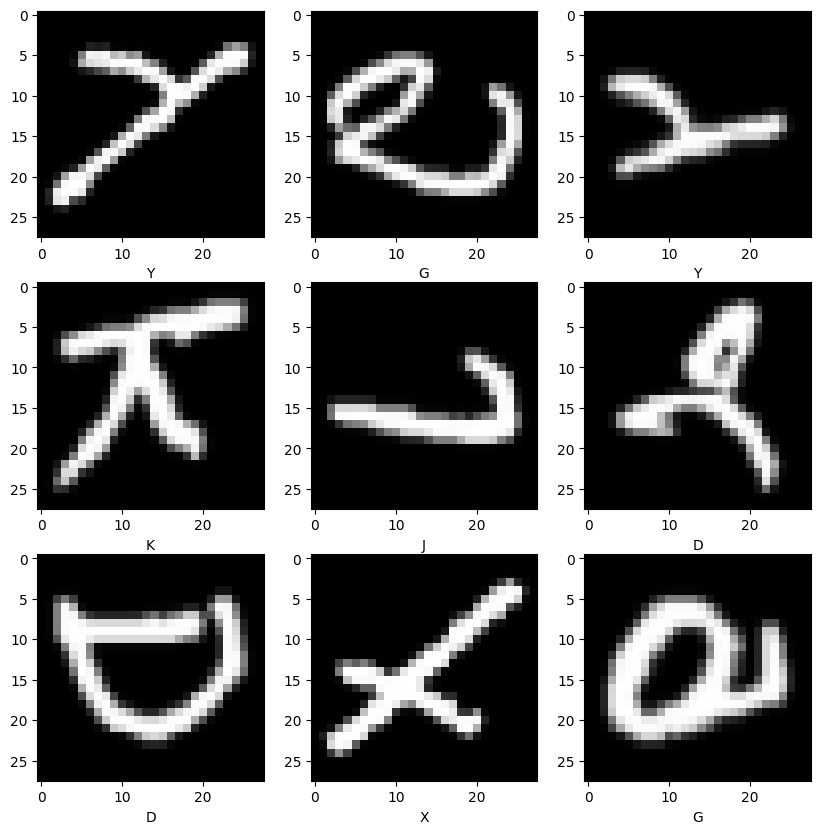

In [12]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.grid(False)
    plt.imshow(image_train[i], cmap='gray')
    plt.xlabel(letters[label_train[i]])
plt.show()

### Normalize Pixel Values

In [ ]:
# normalize the pixel by dividing by 255

image_train=image_train/255
image_test=image_test/255

### Implement A Fully Connected Neural Network 

In [14]:
def build_model_and_compile(layers_array,optimizer,loss,metrics):
    """
    parametrs:layers_array,optimizer,loss,metrics
    return tuple (model,model summary)
    """
    model=models.Sequential(layers_array)

    model.compile(optimizer=optimizer,loss=loss,metrics=metrics)
    return (model,model.summary())

### Compile And Train The Model. 

In [15]:
model,summary=build_model_and_compile([
    layers.Flatten(input_shape=(28,28)),

    layers.Dense(128,activation="relu"),
    layers.Dense(64,activation="relu"),

    layers.Dense(26,activation="softmax")
],optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

summary

c:\Users\GIGABYTE\Desktop\CAP\Advanced Machine Learning Topics\Assignments\Assignment-1 basic ann\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,426 (431.35 KB)

 Trainable params: 110,426 (431.35 KB)

 Non-trainable params: 0 (0.00 B)

###  Implement Early Stopping and Learning Rate Scheduling

In [ ]:
# create learning rate scheduler by decay epochs 5

from tensorflow.keras.callbacks import LearningRateScheduler

def learning_rate_scheduler(epoch):
    initial_lr=0.001
    decay_factor=0.1
    decay_epochs=5
    lr = initial_lr * (decay_factor ** (epoch // decay_epochs))
    return lr

lr_scheduler=LearningRateScheduler(learning_rate_scheduler)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping=EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

### Train the model using cross-validation and report performance. 

In [18]:
def fit_model(model,image_train,label_train,validation_split,epochs,batch_size,callbacks):
    """
    paramters:model:tf,image_train:data,label_train:data,validation_split:float,epochs:int,batch_size:int,callbacks:list
    return: the history
    """
    history = model.fit(image_train, label_train, validation_split=validation_split,
                            epochs=epochs, batch_size=batch_size, callbacks=callbacks)
    
    return history

In [19]:
history=fit_model(model=model,image_train=image_train,label_train=label_train,
                    validation_split=0.2,epochs=20,batch_size=16,callbacks=[early_stopping,lr_scheduler])

Epoch 1/20
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6565 - loss: 1.1563 - val_accuracy: 0.8470 - val_loss: 0.4989 - learning_rate: 0.0010
Epoch 2/20
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8558 - loss: 0.4544 - val_accuracy: 0.8657 - val_loss: 0.4325 - learning_rate: 0.0010
Epoch 3/20
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8816 - loss: 0.3643 - val_accuracy: 0.8726 - val_loss: 0.4050 - learning_rate: 0.0010
Epoch 4/20
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8971 - loss: 0.3123 - val_accuracy: 0.8832 - val_loss: 0.3817 - learning_rate: 0.0010
Epoch 5/20
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9054 - loss: 0.2782 - val_accuracy: 0.8797 - val_loss: 0.3893 - learning_rate: 0.0010
Epoch 6/20
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9312 - loss: 0.2011 - val_accuracy: 0.9025 - val_loss: 0.3247 - learning_rate: 1.0000e-04
Epoch 7/20
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0

### Evaluate And Analyze Performance

In [20]:
def evaluate_model(model,image_test,label_test,verbose):
    """
    paramters:model:tf,image_test:data,label_test:data,verbose:int
    return:tuple of test_loss and test_acc
    """
    test_loss, test_acc = model.evaluate(image_test, label_test, verbose=verbose)
    return (test_loss, test_acc)

In [21]:
test_loss, test_acc=evaluate_model(model=model,image_test=image_test,label_test=label_test,verbose=2)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

463/463 - 0s - 1ms/step - accuracy: 0.8855 - loss: 0.3740
Test accuracy: 0.8855405449867249
Test loss: 0.3739738464355469


### Compare Performance Across Different Folds In Cross-validation.

In [22]:
from sklearn.model_selection import KFold

def cross_validation_model(image_train,label_train,k=5):
    kfold=KFold(n_splits=k,shuffle=True,random_state=42)

    fold_number=1
    scores=[]

    for train_idx,val_idx in kfold.split(image_train):
        print(f"Training on fold {fold_number/k}...")
        history = model.fit(image_train[train_idx], label_train[train_idx], validation_data=(image_train[val_idx], label_train[val_idx]),
                        epochs=10, batch_size=16, callbacks=[early_stopping,lr_scheduler])
        
        _, accuracy = model.evaluate(image_train[val_idx], label_train[val_idx], verbose=2)
        scores.append(accuracy)
        print(f"Fold {fold_number} Accuracy: {accuracy:.4f}")
        fold_number+=1
    print(f"Mean Accuracy: {np.mean (scores):.4f}, Standard Deviation:{np.std(scores):.4f}")
    print(scores)

cross_validation_model(image_train,label_train)

Training on fold 0.2...
Epoch 1/10
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9060 - loss: 0.2837 - val_accuracy: 0.9053 - val_loss: 0.2877 - learning_rate: 0.0010
Epoch 2/10
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9126 - loss: 0.2501 - val_accuracy: 0.8994 - val_loss: 0.3166 - learning_rate: 0.0010
Epoch 3/10
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9222 - loss: 0.2262 - val_accuracy: 0.8934 - val_loss: 0.3287 - learning_rate: 0.0010
Epoch 4/10
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9257 - loss: 0.2113 - val_accuracy: 0.8999 - val_loss: 0.3136 - learning_rate: 0.0010
Epoch 5/10
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9304 - loss: 0.1972 - val_accuracy: 0.8954 - val_loss: 0.3291 - learning_rate: 0.0010
Epoch 6/10
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9492 - loss: 0.1411 - val_accuracy: 0.9133 - val_loss: 0.2779 - learning_rate: 1.0000e-04
Epoch 7/10
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 13s 3m

# Visualizing and Analyzing Model Performance 

### Plot training and validation accuracy and identify overfitting or underfitting. 

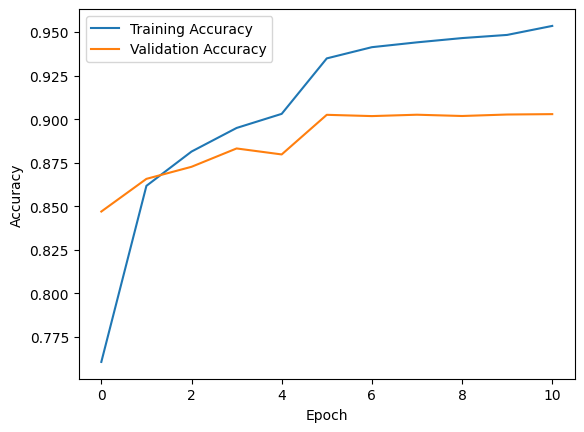

In [23]:
def visualizing_accuracy_validation(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

visualizing_accuracy_validation(history=history)

### Display the confusion matrix and identify common misclassifications.

In [24]:
def compute_predictions(model,image_test):
    predictions = model.predict(image_test)
    predictions=np.argmax(predictions, axis = 1)

    return predictions

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def visualizing_confusion_matrix(model,image_test,label_test):
    predictions = compute_predictions(model=model,image_test=image_test)

    cm = confusion_matrix(label_test, predictions)
    plt.figure(figsize=(10, 9))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step


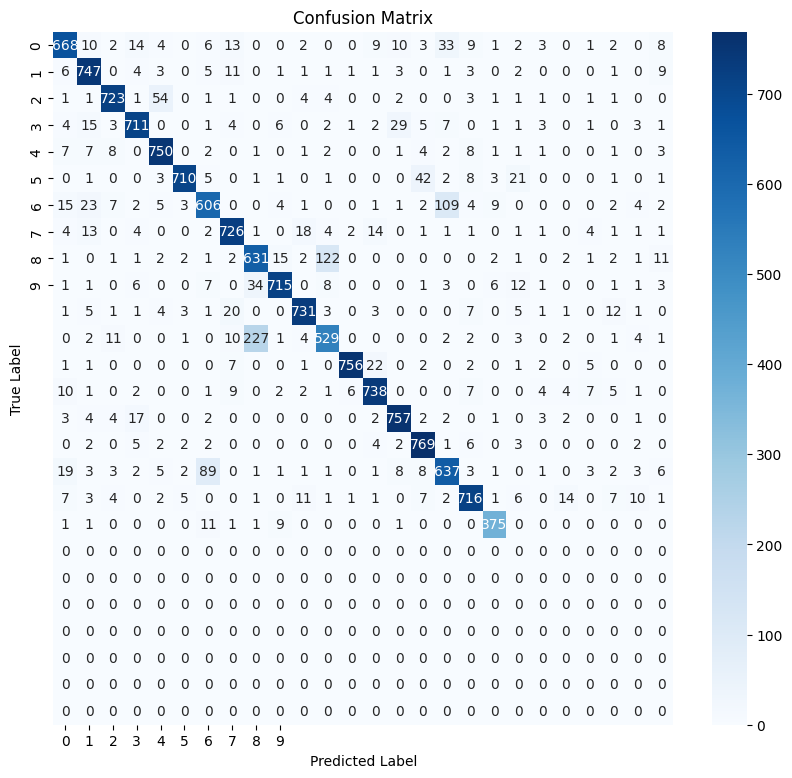

In [26]:
visualizing_confusion_matrix(model=model,image_test=image_test,label_test=label_test)

### Visualize misclassified images show incorrectly predicted images with actual vs predicted labels 

463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step


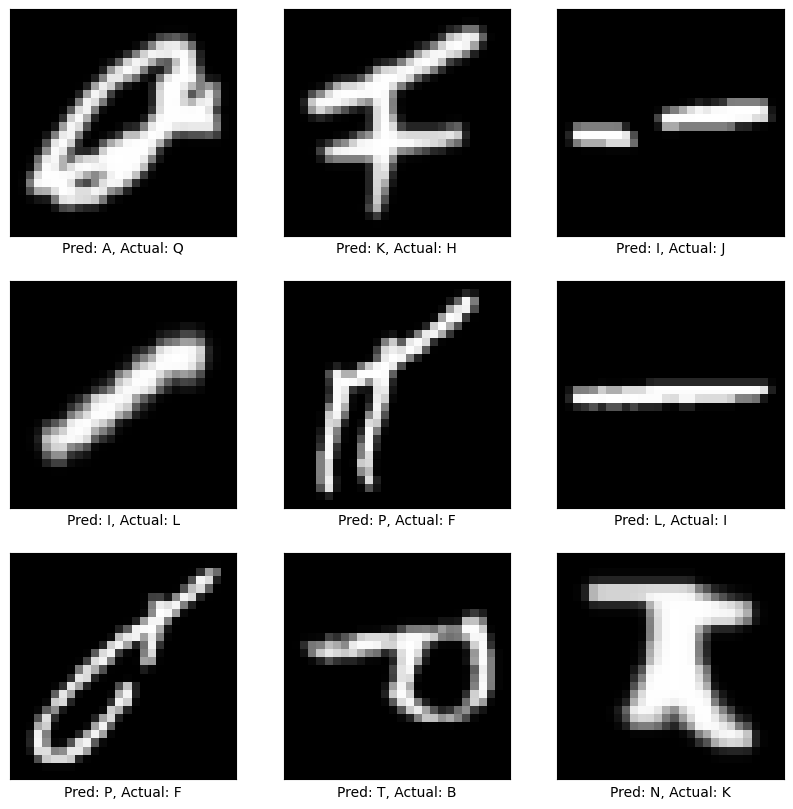

In [27]:
def visualize_misclassified(model,image_test):
    predictions=compute_predictions(model=model,image_test=image_test)

    misclassified_indices = np.where(predictions != label_test)[0]
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(misclassified_indices[:9]):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image_test[idx], cmap='gray')
        plt.xlabel(f"Pred: {letters[predictions[idx]]}, Actual: {letters[label_test[idx]]}")
        plt.xticks([])
        plt.yticks([])
    plt.show()

visualize_misclassified(model=model,image_test=image_test)

### Which letter is the most misclassified

In [28]:
def most_misclassified(model,image_test):
    predictions=compute_predictions(model=model,image_test=image_test)

    misclassified_indices = np.where(predictions != label_test)[0]

    misclassified_labels = label_test[misclassified_indices]
    unique_misclassified_labels, counts = np.unique(misclassified_labels, return_counts=True)

    max_occurrence_index = np.argmax(counts)
    most_misclassified_label = unique_misclassified_labels[max_occurrence_index]
    most_misclassified_count = counts[max_occurrence_index]

    most_misclassified_indices = misclassified_indices[misclassified_labels == most_misclassified_label]
    
    return (most_misclassified_label,most_misclassified_count)

    

In [29]:
most_misclassified_label,most_misclassified_count=most_misclassified(model=model,image_test=image_test)

print(f"Most misclassified label: {most_misclassified_label}")
print(f"Number of misclassifications: {most_misclassified_count}")

463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
Most misclassified label: 11
Number of misclassifications: 271


###  Analyze hidden layer representations

In [30]:
def hidden_layer_representations(model):
    weights, biases = model.layers[1].get_weights()
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        weights_normalized = (weights - weights.min()) / (weights.max() - weights.min())
        plt.imshow(weights_normalized[:, i].reshape(28, 28), cmap='gray')
        plt.imshow(weights[:, i].reshape(28, 28), cmap='gray')
    plt.show()

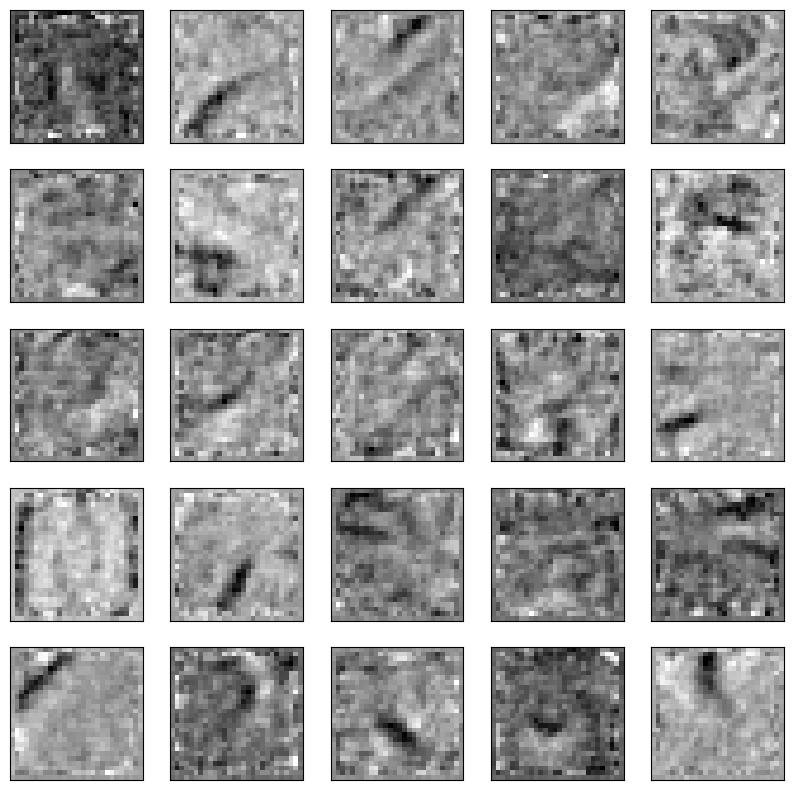

In [31]:
hidden_layer_representations(model=model)

#  Experimenting with Model Improvements  

In [32]:
model,summary=build_model_and_compile([
    layers.Flatten(input_shape=(28,28)),

    layers.Dense(128,activation="relu"),
    layers.Dense(64,activation="relu"),

    layers.Dense(26,activation="sigmoid")
],optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

history=fit_model(model=model,image_train=image_train,label_train=label_train,
                    validation_split=0.2,epochs=20,batch_size=16,callbacks=[early_stopping,lr_scheduler])

test_loss, test_acc=evaluate_model(model=model,image_test=image_test,label_test=label_test,verbose=2)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

c:\Users\GIGABYTE\Desktop\CAP\Advanced Machine Learning Topics\Assignments\Assignment-1 basic ann\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,426 (431.35 KB)

 Trainable params: 110,426 (431.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6621 - loss: 1.1511 - val_accuracy: 0.8456 - val_loss: 0.5015 - learning_rate: 0.0010
Epoch 2/20
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8586 - loss: 0.4540 - val_accuracy: 0.8678 - val_loss: 0.4258 - learning_rate: 0.0010
Epoch 3/20
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8839 - loss: 0.3611 - val_accuracy: 0.8685 - val_loss: 0.4345 - learning_rate: 0.0010
Epoch 4/20
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8985 - loss: 0.3112 - val_accuracy: 0.8804 - val_loss: 0.3801 - learning_rate: 0.0010
Epoch 5/20
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9036 - loss: 0.2823 - val_accuracy: 0.8795 - val_loss: 0.3897 - learning_rate: 0.0010
Epoch 6/20
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9304 - loss: 0.1993 - val_accuracy: 0.9008 - val_loss: 0.3293 - learning_rate: 1.0000e-04
Epoch 7/20
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9418

accuracy validation visualizing


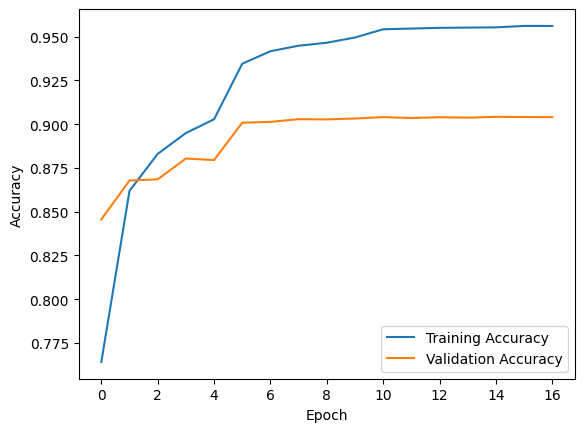

visualizing confusion matrix
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


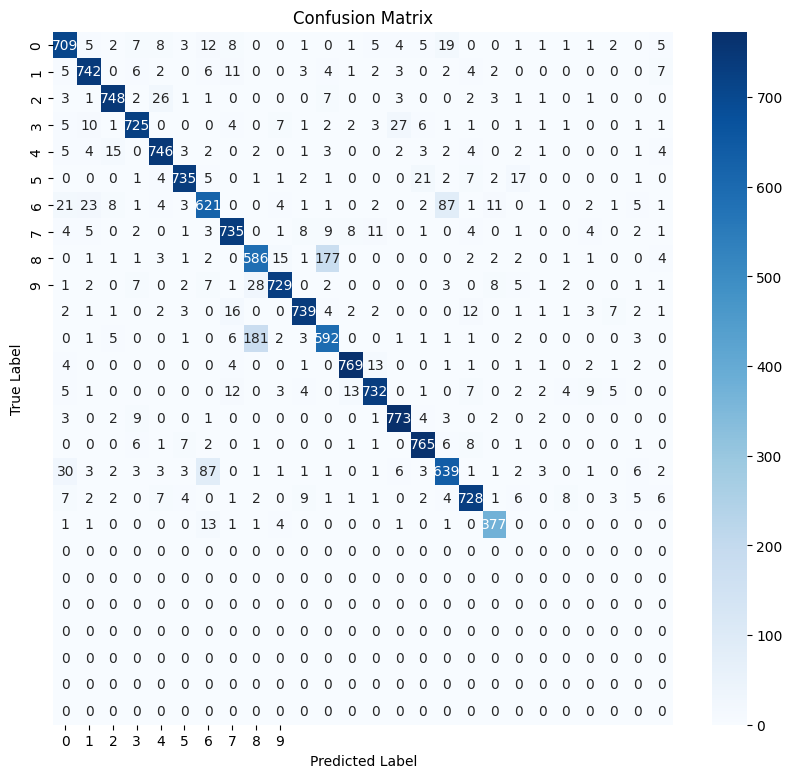

visualize misclassified
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


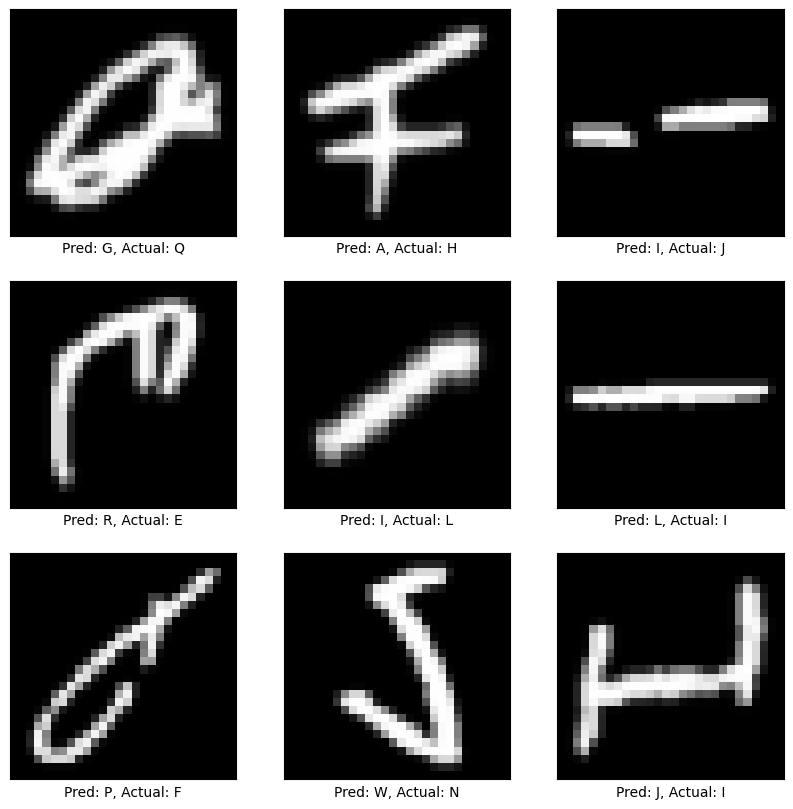

most misclassified
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step
hidden layer representations


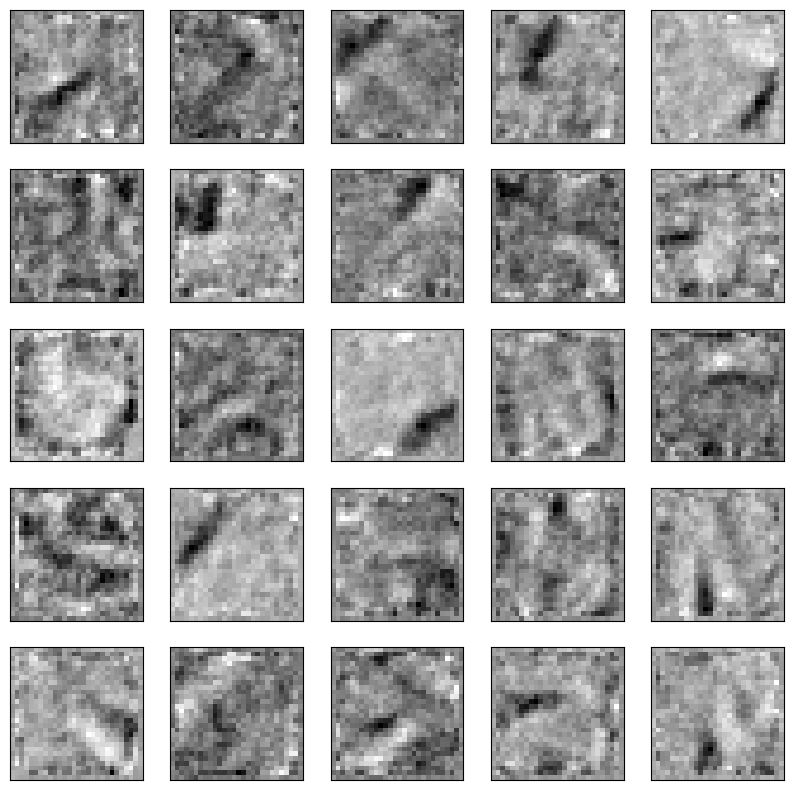

In [33]:
print("accuracy validation visualizing")
visualizing_accuracy_validation(history=history)
print("visualizing confusion matrix")
visualizing_confusion_matrix(model=model,image_test=image_test,label_test=label_test)
print("visualize misclassified")
visualize_misclassified(model=model,image_test=image_test)
print("most misclassified")
most_misclassified(model=model,image_test=image_test)
print("hidden layer representations")
hidden_layer_representations(model=model)

In [34]:
model,summary=build_model_and_compile([
    layers.Flatten(input_shape=(28,28)),

    layers.Dense(128,activation="relu"),
    layers.Dense(64,activation="relu"),
    layers.Dense(32,activation="relu"),

    layers.Dense(26,activation="softmax")
],optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

history=fit_model(model=model,image_train=image_train,label_train=label_train,
                    validation_split=0.2,epochs=20,batch_size=16,callbacks=[early_stopping,lr_scheduler])

test_loss, test_acc=evaluate_model(model=model,image_test=image_test,label_test=label_test,verbose=2)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

c:\Users\GIGABYTE\Desktop\CAP\Advanced Machine Learning Topics\Assignments\Assignment-1 basic ann\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 26)             │           858 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,674 (436.23 KB)

 Trainable params: 111,674 (436.23 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.6438 - loss: 1.2075 - val_accuracy: 0.8346 - val_loss: 0.5268 - learning_rate: 0.0010
Epoch 2/20
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8505 - loss: 0.4702 - val_accuracy: 0.8503 - val_loss: 0.4748 - learning_rate: 0.0010
Epoch 3/20
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8772 - loss: 0.3784 - val_accuracy: 0.8757 - val_loss: 0.3968 - learning_rate: 0.0010
Epoch 4/20
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8906 - loss: 0.3239 - val_accuracy: 0.8754 - val_loss: 0.3991 - learning_rate: 0.0010
Epoch 5/20
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8988 - loss: 0.2929 - val_accuracy: 0.8762 - val_loss: 0.4113 - learning_rate: 0.0010
Epoch 6/20
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9276 - loss: 0.2103 - val_accuracy: 0.9003 - val_loss: 0.3293 - learning_rate: 1.0000e-04
Epoch 7/20
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9414

accuracy validation visualizing


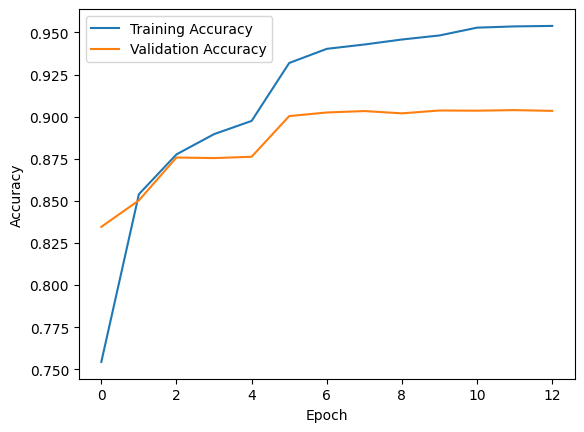

visualizing confusion matrix
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step


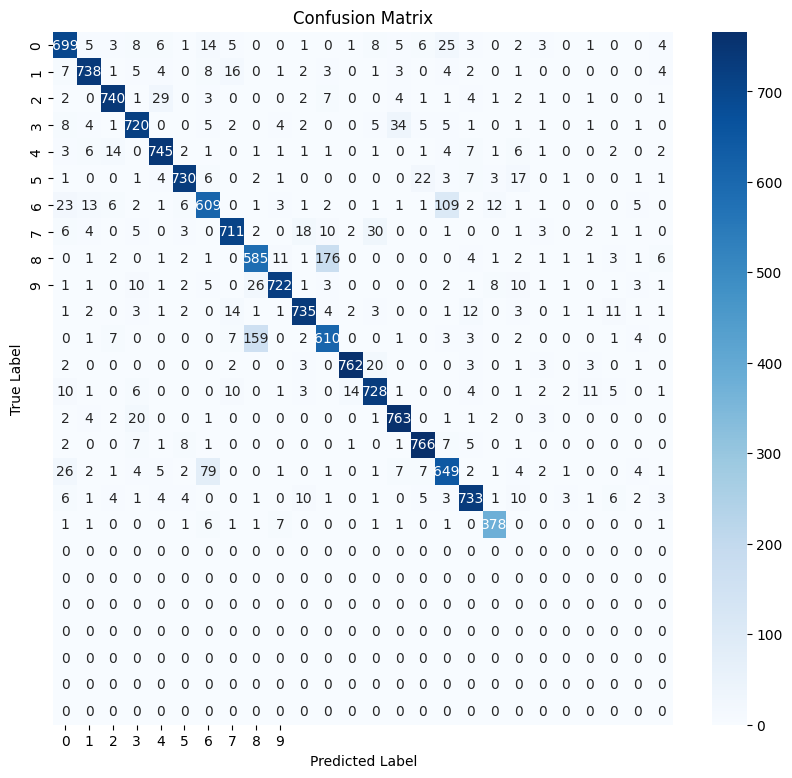

visualize misclassified
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step


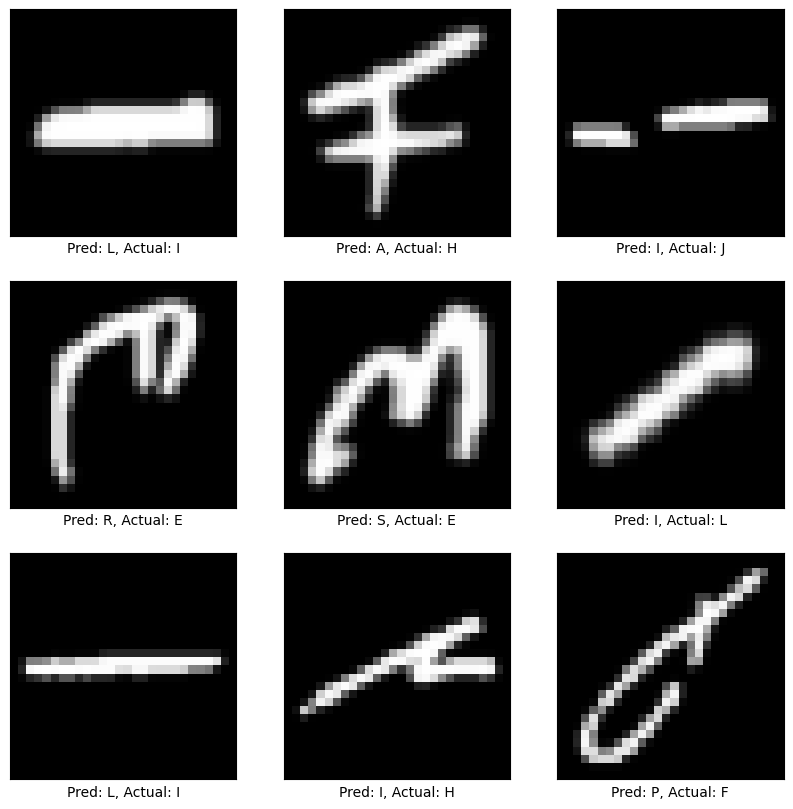

most misclassified
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step
hidden layer representations


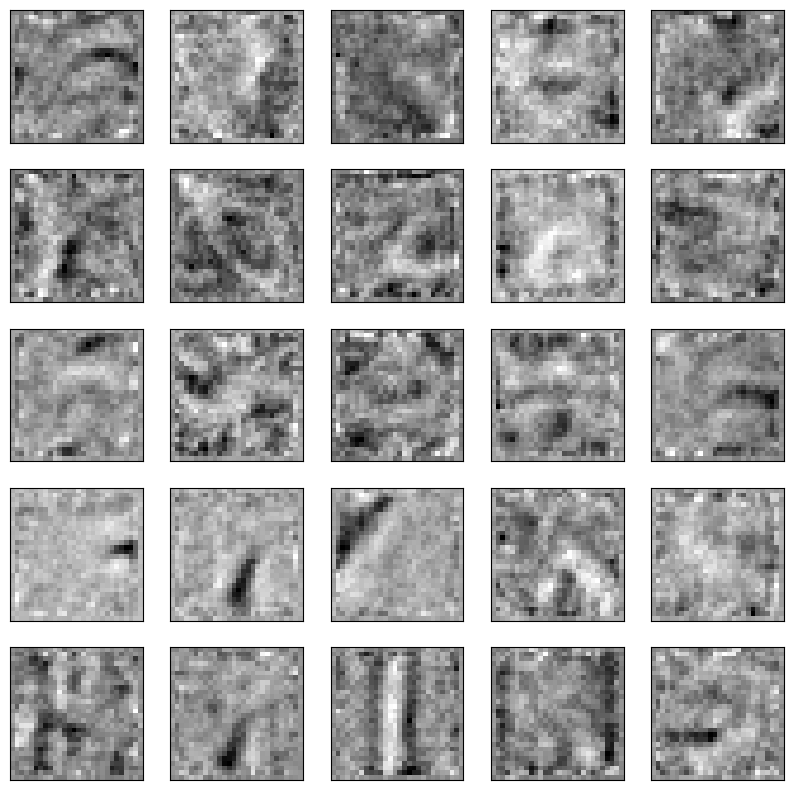

In [35]:
print("accuracy validation visualizing")
visualizing_accuracy_validation(history=history)
print("visualizing confusion matrix")
visualizing_confusion_matrix(model=model,image_test=image_test,label_test=label_test)
print("visualize misclassified")
visualize_misclassified(model=model,image_test=image_test)
print("most misclassified")
most_misclassified(model=model,image_test=image_test)
print("hidden layer representations")
hidden_layer_representations(model=model)

In [36]:
model,summary=build_model_and_compile([
    layers.Flatten(input_shape=(28,28)),

    layers.Dense(128,activation="relu"),
    layers.Dense(64,activation="relu"),
    layers.Dense(32,activation="relu"),
    layers.Dense(16,activation="relu"),

    layers.Dense(26,activation="softmax")
],optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

history=fit_model(model=model,image_train=image_train,label_train=label_train,
                    validation_split=0.2,epochs=15,batch_size=10,callbacks=[early_stopping,lr_scheduler])

test_loss, test_acc=evaluate_model(model=model,image_test=image_test,label_test=label_test,verbose=2)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

c:\Users\GIGABYTE\Desktop\CAP\Advanced Machine Learning Topics\Assignments\Assignment-1 basic ann\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 26)             │           442 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,786 (436.66 KB)

 Trainable params: 111,786 (436.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
7104/7104 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.5998 - loss: 1.3636 - val_accuracy: 0.8279 - val_loss: 0.5619 - learning_rate: 0.0010
Epoch 2/15
7104/7104 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.8420 - loss: 0.5052 - val_accuracy: 0.8521 - val_loss: 0.4783 - learning_rate: 0.0010
Epoch 3/15
7104/7104 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.8705 - loss: 0.4059 - val_accuracy: 0.8620 - val_loss: 0.4604 - learning_rate: 0.0010
Epoch 4/15
7104/7104 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.8831 - loss: 0.3565 - val_accuracy: 0.8648 - val_loss: 0.4391 - learning_rate: 0.0010
Epoch 5/15
7104/7104 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.8949 - loss: 0.3208 - val_accuracy: 0.8783 - val_loss: 0.4080 - learning_rate: 0.0010
Epoch 6/15
7104/7104 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.9251 - loss: 0.2285 - val_accuracy: 0.8967 - val_loss: 0.3460 - learning_rate: 1.0000e-04
Epoch 7/15
7104/7104 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy:

accuracy validation visualizing


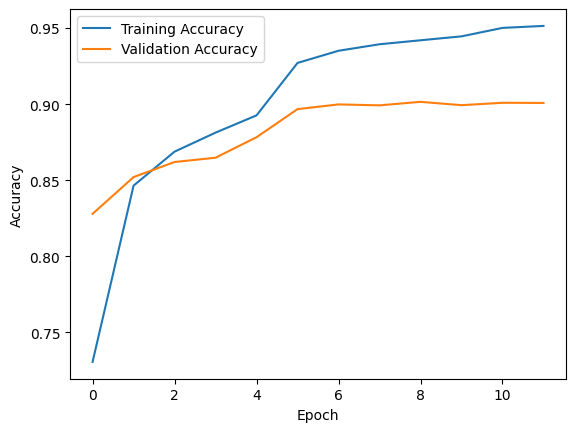

visualizing confusion matrix
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step


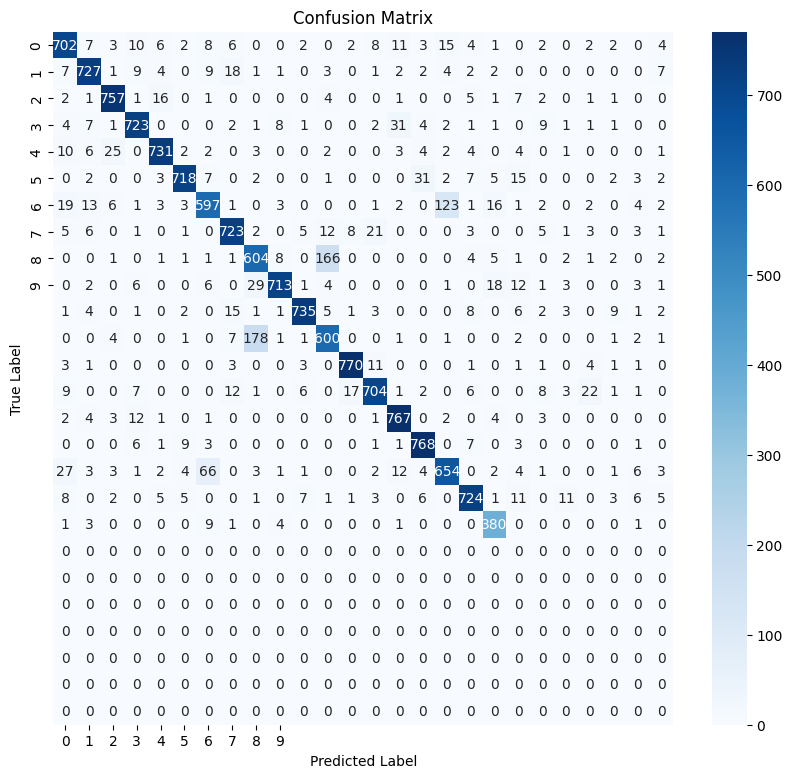

visualize misclassified
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step


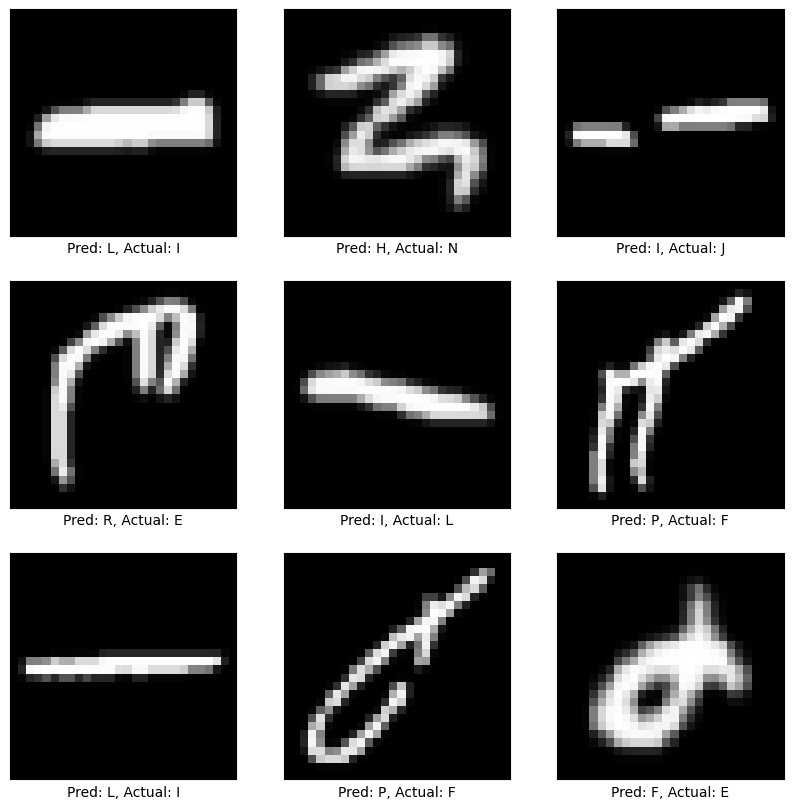

most misclassified
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
hidden layer representations


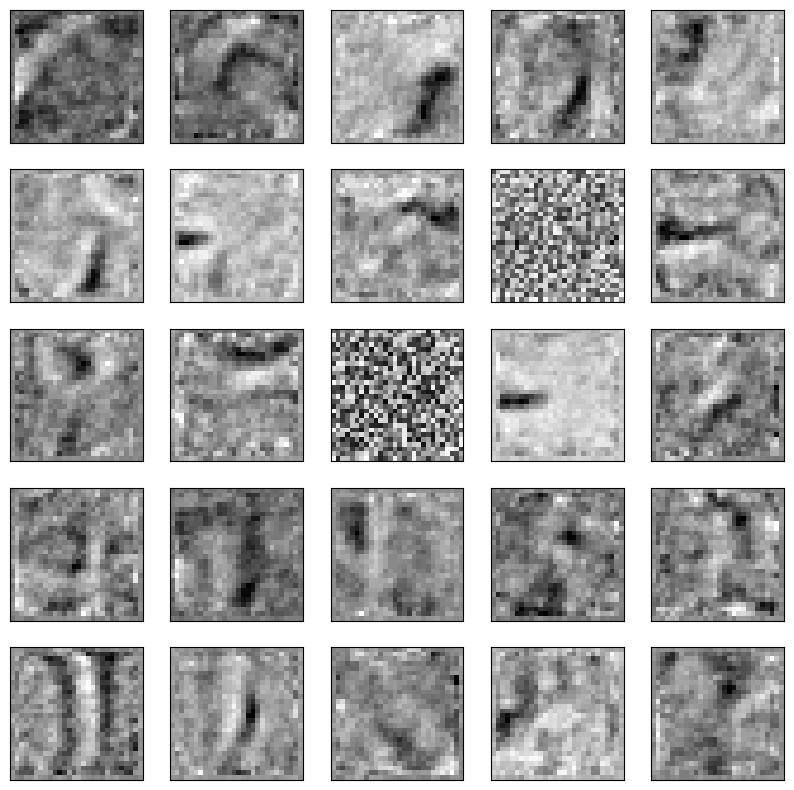

In [37]:
print("accuracy validation visualizing")
visualizing_accuracy_validation(history=history)
print("visualizing confusion matrix")
visualizing_confusion_matrix(model=model,image_test=image_test,label_test=label_test)
print("visualize misclassified")
visualize_misclassified(model=model,image_test=image_test)
print("most misclassified")
most_misclassified(model=model,image_test=image_test)
print("hidden layer representations")
hidden_layer_representations(model=model)

In [38]:
model,summary=build_model_and_compile([
    layers.Flatten(input_shape=(28,28)),

    layers.Dense(128,activation="relu"),
    layers.Dense(64,activation="relu"),
    layers.Dense(32,activation="relu"),

    layers.Dense(26,activation="softmax")
],optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

history=fit_model(model=model,image_train=image_train,label_train=label_train,
                    validation_split=0.2,epochs=20,batch_size=30,callbacks=[early_stopping,lr_scheduler])

test_loss, test_acc=evaluate_model(model=model,image_test=image_test,label_test=label_test,verbose=2)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

c:\Users\GIGABYTE\Desktop\CAP\Advanced Machine Learning Topics\Assignments\Assignment-1 basic ann\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 26)             │           858 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,674 (436.23 KB)

 Trainable params: 111,674 (436.23 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6257 - loss: 1.2940 - val_accuracy: 0.8169 - val_loss: 0.5792 - learning_rate: 0.0010
Epoch 2/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8443 - loss: 0.4974 - val_accuracy: 0.8620 - val_loss: 0.4512 - learning_rate: 0.0010
Epoch 3/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8747 - loss: 0.3909 - val_accuracy: 0.8605 - val_loss: 0.4400 - learning_rate: 0.0010
Epoch 4/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8912 - loss: 0.3376 - val_accuracy: 0.8744 - val_loss: 0.4076 - learning_rate: 0.0010
Epoch 5/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9002 - loss: 0.2985 - val_accuracy: 0.8830 - val_loss: 0.3796 - learning_rate: 0.0010
Epoch 6/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9276 - loss: 0.2154 - val_accuracy: 0.8974 - val_loss: 0.3385 - learning_rate: 1.0000e-04
Epoch 7/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9343

accuracy validation visualizing


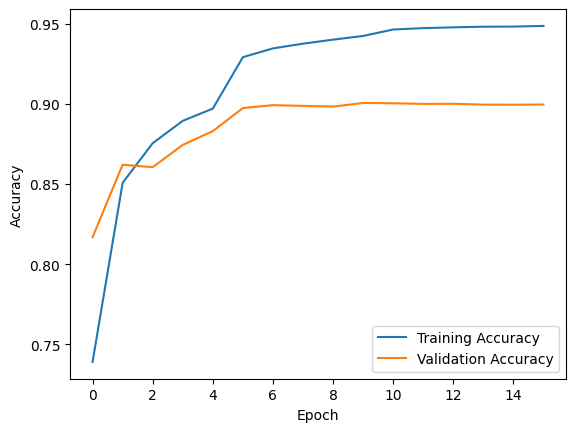

visualizing confusion matrix
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step


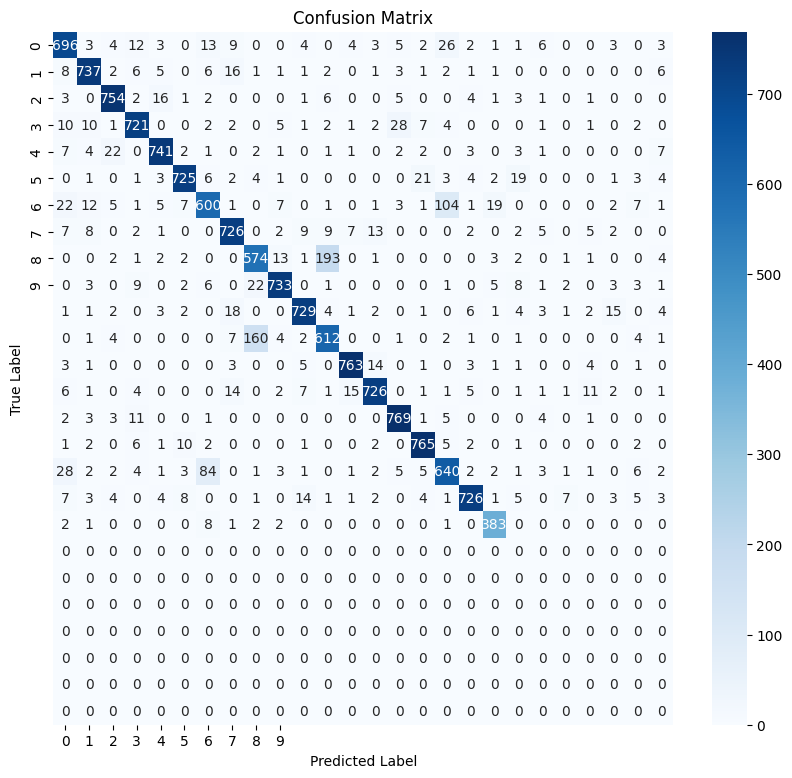

visualize misclassified
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step


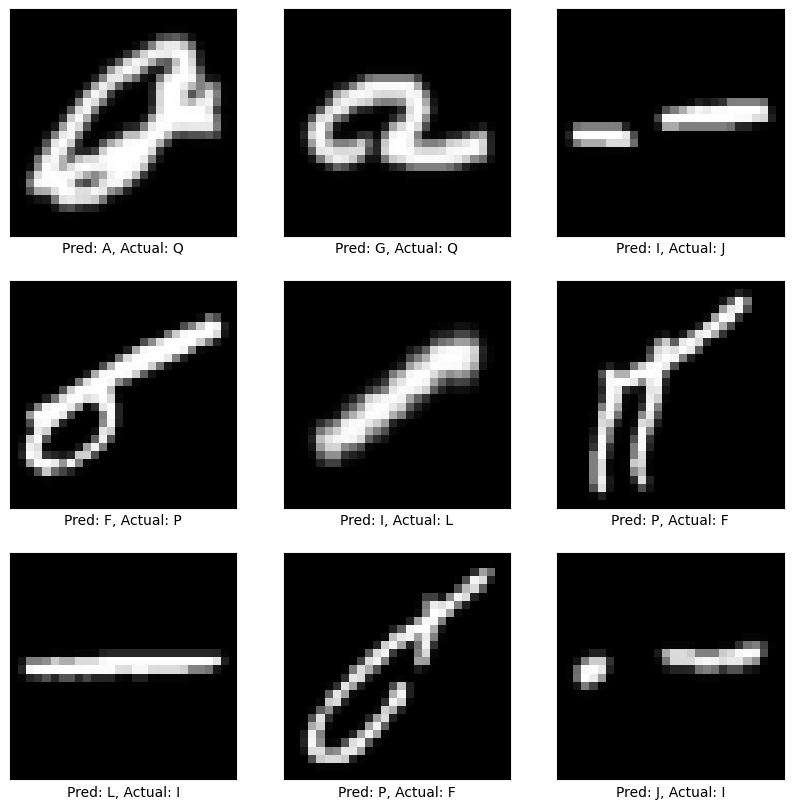

most misclassified
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
hidden layer representations


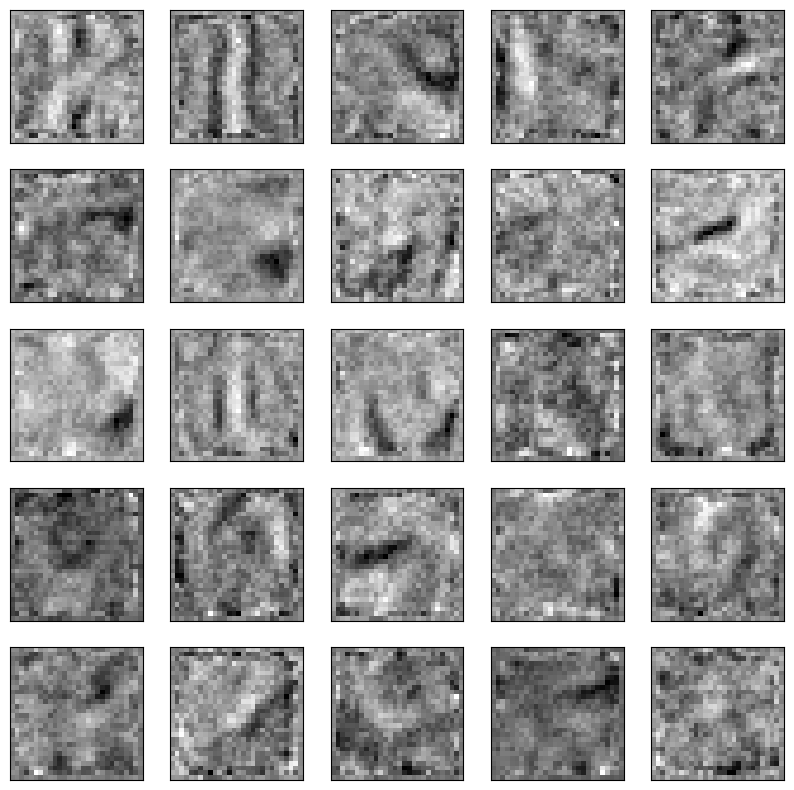

In [39]:
print("accuracy validation visualizing")
visualizing_accuracy_validation(history=history)
print("visualizing confusion matrix")
visualizing_confusion_matrix(model=model,image_test=image_test,label_test=label_test)
print("visualize misclassified")
visualize_misclassified(model=model,image_test=image_test)
print("most misclassified")
most_misclassified(model=model,image_test=image_test)
print("hidden layer representations")
hidden_layer_representations(model=model)

In [45]:
model,summary=build_model_and_compile([
    layers.Flatten(input_shape=(28,28)),

    layers.Dense(128,activation="relu"),
    layers.Dense(64,activation="relu"),
    layers.Dense(32,activation="relu"),
    layers.Dense(16,activation="relu"),

    layers.Dense(26,activation="softmax")
],optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

history=fit_model(model=model,image_train=image_train,label_train=label_train,
                    validation_split=0.2,epochs=10,batch_size=5,callbacks=[early_stopping,lr_scheduler])

test_loss, test_acc=evaluate_model(model=model,image_test=image_test,label_test=label_test,verbose=2)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_9 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 26)             │           442 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,786 (436.66 KB)

 Trainable params: 111,786 (436.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
14208/14208 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 0.6141 - loss: 1.3049 - val_accuracy: 0.8219 - val_loss: 0.5848 - learning_rate: 0.0010
Epoch 2/10
14208/14208 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.8395 - loss: 0.5137 - val_accuracy: 0.8462 - val_loss: 0.5019 - learning_rate: 0.0010
Epoch 3/10
14208/14208 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.8670 - loss: 0.4186 - val_accuracy: 0.8568 - val_loss: 0.4741 - learning_rate: 0.0010
Epoch 4/10
14208/14208 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.8785 - loss: 0.3816 - val_accuracy: 0.8576 - val_loss: 0.4702 - learning_rate: 0.0010
Epoch 5/10
14208/14208 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.8877 - loss: 0.3500 - val_accuracy: 0.8709 - val_loss: 0.4363 - learning_rate: 0.0010
Epoch 6/10
14208/14208 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.9175 - loss: 0.2481 - val_accuracy: 0.8971 - val_loss: 0.3490 - learning_rate: 1.0000e-04
Epoch 7/10
14208/14208 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/st

accuracy validation visualizing


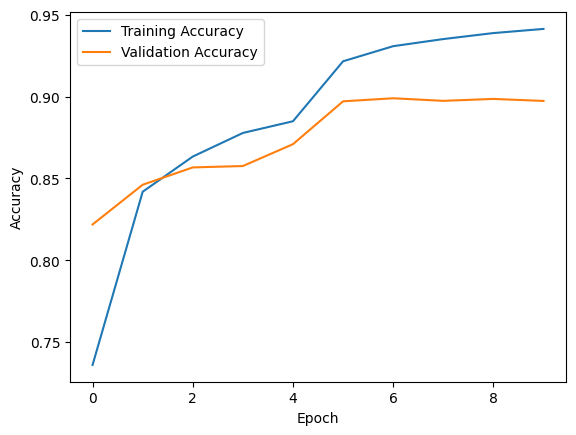

visualizing confusion matrix
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step


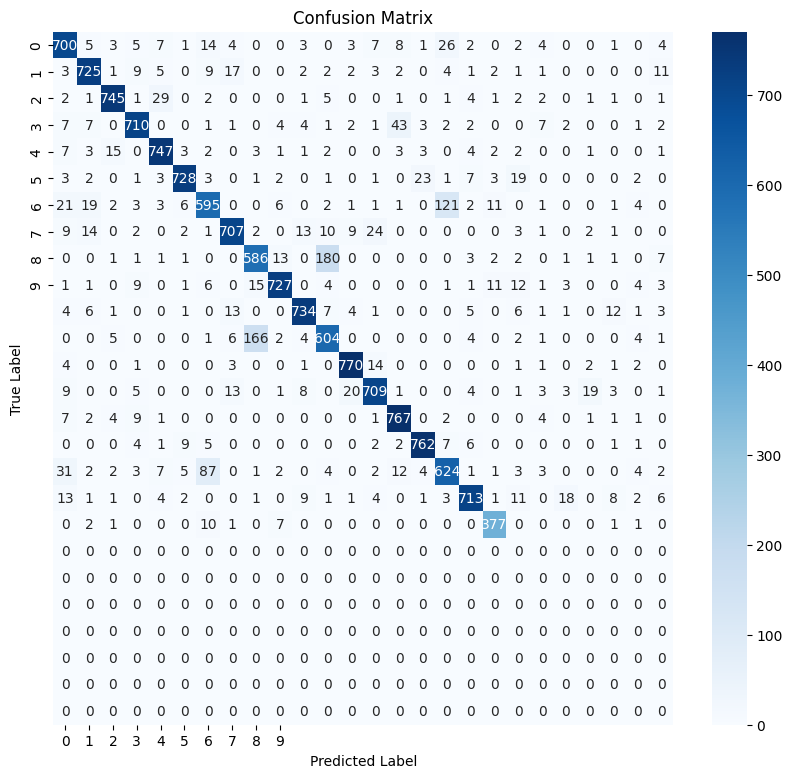

visualize misclassified
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step


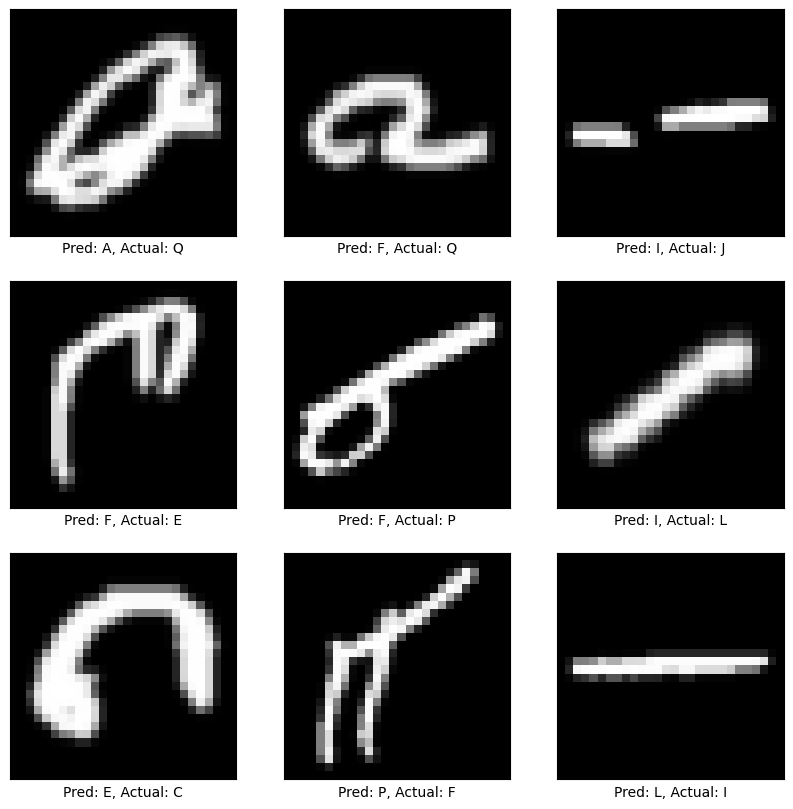

most misclassified
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step
hidden layer representations


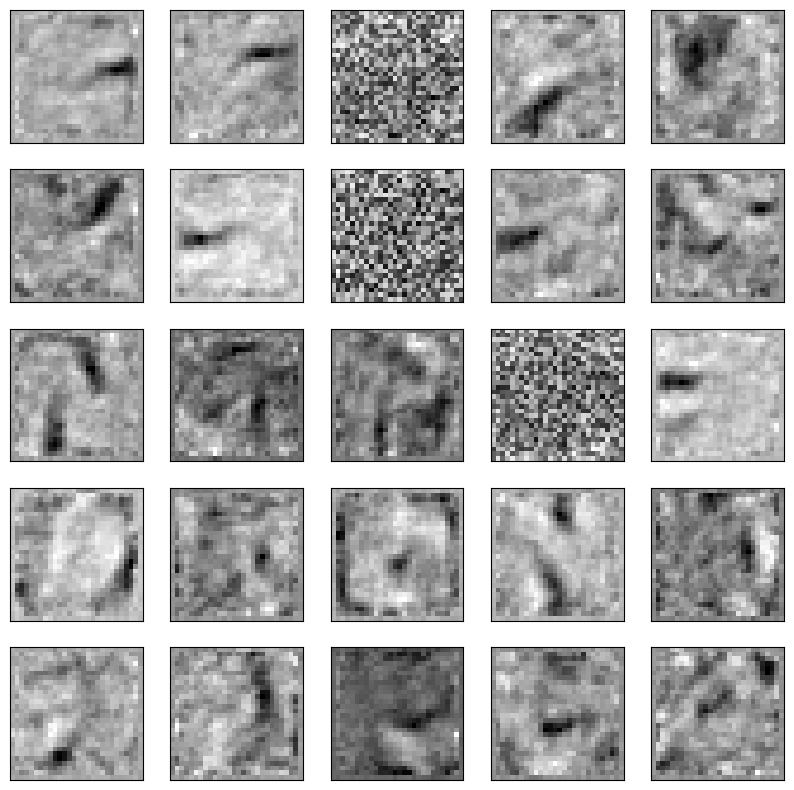

In [46]:
print("accuracy validation visualizing")
visualizing_accuracy_validation(history=history)
print("visualizing confusion matrix")
visualizing_confusion_matrix(model=model,image_test=image_test,label_test=label_test)
print("visualize misclassified")
visualize_misclassified(model=model,image_test=image_test)
print("most misclassified")
most_misclassified(model=model,image_test=image_test)
print("hidden layer representations")
hidden_layer_representations(model=model)

### Conclusion

In this project, we built a basic Artificial Neural Network (ANN) to predict handwritten letters. Through experimentation, we observed the following:

- **Increasing hidden layers** improved accuracy, but the improvement was not perfect. Using more than two hidden layers gave better results than a shallower network.
- **Increasing batch size** led to longer training times and a slight increase in accuracy but also increased **overfitting**.
- **Decreasing batch size** made training faster and helped reduce overfitting, but the accuracy improvement was minimal.

